In [0]:
!pip install git+https://github.com/ncullen93/torchsample

  Cloning https://github.com/ncullen93/torchsample to /tmp/pip-req-build-310wxtwd
  Running command git clone -q https://github.com/ncullen93/torchsample /tmp/pip-req-build-310wxtwd
  Created wheel for torchsample: filename=torchsample-0.1.3-cp36-none-any.whl size=43417 sha256=ee2fcad81c2dc2d1f58cdc60e14ecec79719e5aacadb1283ee50e47e0fbbb985
  Stored in directory: /tmp/pip-ephem-wheel-cache-bn1if06b/wheels/88/c7/72/14cd9a173eed1e29d0b17d866e7d9ee511d31a834aedd27489
Successfully built torchsample


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajdeepbasu","key":"574831de99a2190403384130e9bd9a4a"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
sudalairajkumar/novel-corona-virus-2019-dataset             Novel Corona Virus 2019 Dataset                     335KB  2020-03-08 04:52:10          25702  
kimjihoo/coronavirusdataset                                 Coronavirus-Dataset                                  28KB  2020-03-08 04:57:59           7494  
rupals/gpu-runtime                                          Segmentation GPU Kernel Performance Dataset           4MB  2020-03-01 10:04:27            101  
shank885/knife-dataset                                      Knife Dataset                                         1MB  2020-03-02 06:43:53            126  
shivamb/real-or-fake-fake-jobposting-prediction             [Rea

In [0]:
!kaggle datasets download -d kmkarakaya/logos-bk-kfc-mcdonald-starbucks-subway-none
!ls

 63% 41.0M/65.0M [00:00<00:00, 41.0MB/s]
100% 65.0M/65.0M [00:00<00:00, 111MB/s] 
faces_old      logos-bk-kfc-mcdonald-starbucks-subway-none.zip
faces_old.zip  sample_data
kaggle.json    siamese_network-Mar-08-2020_2113.pth


In [0]:
!unzip logos-bk-kfc-mcdonald-starbucks-subway-none.zip

In [0]:
%matplotlib inline
# Pytorch imports
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import models
# TorchSample imports
from torchsample.modules import ModuleTrainer
from torchsample.callbacks import EarlyStopping

In [0]:
# Regular package imports
import PIL.ImageOps    
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import shutil
import glob
import time, fnmatch

In [0]:
# os.environ['TORCH_HOME'] = 'models\\' #setting the environment variable

In [0]:
# Load pretrained squeezenet1_1 Model
squeezenet1_1 = models.squeezenet1_1(pretrained=False)

In [0]:
# Freeze model parameters
for param in squeezenet1_1.parameters():
    param.requires_grad = False

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [0]:
class Config():
    training_dir = "./logos3/train/"
    testing_dir = "./logos3/test/"
    train_batch_size = 128
    train_number_epochs = 100

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
#         img0 = img0.convert("L")
#         img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [0]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((224,224)),
                                                                      transforms.ToTensor()
                                                                      ]),should_invert=False)

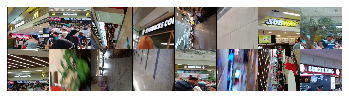

[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]


In [0]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = squeezenet1_1.features

        self.fc1 = nn.Sequential(
            nn.Linear(8*104*104, 64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 10))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [0]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

In [0]:
# es = EarlyStopping(patience=10)

Epoch number 0
 Current loss 2.140778064727783

Epoch number 0
 Current loss 1.0922870635986328

Epoch number 1
 Current loss 0.6859180927276611

Epoch number 1
 Current loss 0.7762271761894226

Epoch number 2
 Current loss 0.7265256643295288

Epoch number 2
 Current loss 0.5670571327209473

Epoch number 3
 Current loss 0.5803194046020508

Epoch number 3
 Current loss 0.4813042879104614

Epoch number 4
 Current loss 0.5613181591033936

Epoch number 4
 Current loss 0.5200276374816895

Epoch number 5
 Current loss 0.5380882024765015

Epoch number 5
 Current loss 0.34480971097946167

Epoch number 6
 Current loss 0.4545677900314331

Epoch number 6
 Current loss 0.34524792432785034

Epoch number 7
 Current loss 0.423419713973999

Epoch number 7
 Current loss 0.43124106526374817

Epoch number 8
 Current loss 0.41488558053970337

Epoch number 8
 Current loss 0.37338536977767944

Epoch number 9
 Current loss 0.3521314263343811

Epoch number 9
 Current loss 0.4280779957771301

Epoch number 10
 

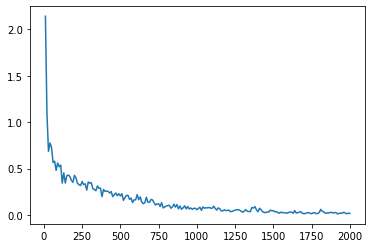

In [0]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
    # if es.step(loss_contrastive):
        # break  # early stop criterion is met, we can stop now
show_plot(counter,loss_history)

In [0]:
t = time.localtime()
timestamp = time.strftime('%b-%d-%Y_%H%M', t)
BACKUP_NAME = ("siamese_network-" + timestamp + '.pth')

In [0]:
# Saving siamese model
torch.save(net, BACKUP_NAME)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SiameseNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# Model class must be defined somewhere
net = torch.load(BACKUP_NAME)

In [0]:
img0 = Image.open('./logos3/test/Starbucks/tunali_image_10.jpg')
# img0 = img0.convert("L")

data_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
img0 = data_transforms(img0)
img0 = img0.view(1, 3, 224, 224)

In [0]:
def listToString(s):    
    # initialize an empty string 
    str1 = ""    
    # traverse in the string   
    for ele in s:  
        str1 += ele    
    # return string   
    return str1

In [0]:
train_folder = './logos3/train/'

images = []
classes = []
for folder in os.listdir(train_folder):
    img_val = (random.sample(glob.glob(train_folder + folder + "/*.jpg"), 1))
    classes.append(os.path.basename(os.path.dirname(listToString(img_val[0]))))
    images.append(listToString(img_val[0]))

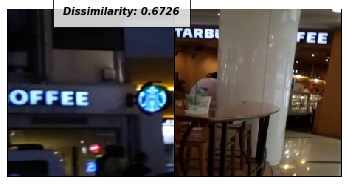

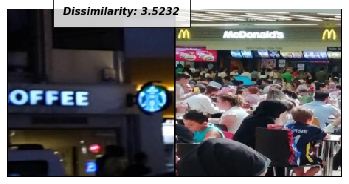

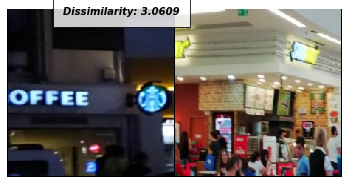

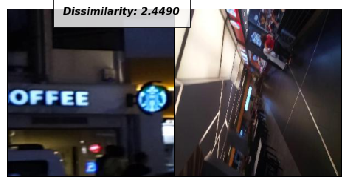

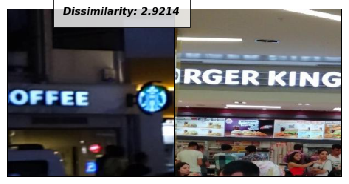

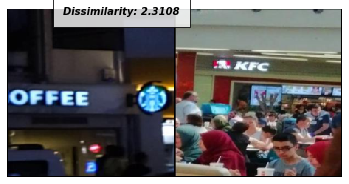

In [0]:
dicts_class = {}
for i in images:
    img1 = Image.open(i)
    data_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    img1 = data_transforms(img1)
    img1 = img1.view(1, 3, 224, 224)
    concatenated = torch.cat((img0,img1),0)
    output1,output2 = net(Variable(img0).cuda(),Variable(img1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.4f}'.format(euclidean_distance.item()))
    dicts_class[os.path.basename(os.path.dirname(listToString(i)))] = euclidean_distance.item()

In [0]:
if(dicts_class[min(dicts_class, key=dicts_class.get)] < 1.0):
    print(min(dicts_class, key=dicts_class.get))
else:
    print("Cannot Identify")

Starbucks
